In [1]:
# A notebook for training a policy based agent using episodes playing a virtual game
import sys, random, os, math, time, itertools
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../app')
from config import Config

%matplotlib inline

In [2]:
class Policy:
    def __init__(self, q_matrix_path=''):
        self.epsilon = 1e-10
        self.high_level_actions = [
            'wait', #if stunned
            'random', #a valid strategy
           'go_opponent_flag',  #go get the flag
           'go_team_flag_area',  #especially if you have the flag
           'go_opponent_flag_carrier', #tag flag carrier
           'go_nearest_opponent', #chase
           'go_nearest_teammate', #a good choice if you have the flag
           'go_nearest_incapacitated_teammate', #revive them
           'gaurd_nearest_teammate',  #get between nearest teammate and enemy
           'gaurd_teammate_flag_carrier', #get between flag carrying teammate and enemy
           'gaurd_team_flag_area', #get between flag area and enemy
           'guard_opponent_flag_area',  #especially if opponent is running the flag
           'run_away_from_nearest_opponent',  #if being chased
           'run_away_from_opponents_centroid' #allows skirting dangerous areas
          ]
        
        self.high_level_states = [
            'opponents_flag_in_play', 
              'team_flag_in_play', 
              'self_incapacitated', 
              'self_has_flag', 
              'self_in_enemy_territory',
              'nearest_teammate_has_flag',
              'nearest_teammate_incapacitated', 
              'nearest_opponent_has_flag',
              'nearest_opponent_incapacitated'
             ]
        
        #states seen in 10K games
        self.state_probs = {}
        if os.path.exists('state_probs.pkl'):
            with open('state_probs.pkl', 'rb') as o:
                self.state_probs = pickle.load(o)
                
        #if these are used there's a possibility a new state will appear
        if self.state_probs:
            self.high_level_state_codes = [s for s,c in self.state_probs.items() if c>100]
        #every possible state
        else: 
            self.high_level_state_codes = [tuple([int(s) for s in seq]) for seq in itertools.product('01', repeat=len(self.high_level_states))]
        
        #if q has already been trained
        if q_matrix_path:
            self.q = np.load(q_matrix_path)
        else:
            self.q = np.zeros((len(self.high_level_state_codes), len(self.high_level_actions)))

        self.prev_hla = 'random'
        
        
    def get_high_level_action(self, player_map_idx, the_map):
        '''Get a high level action for the player based on high level percepts'''    
        #this should only be called for live players, not incapacitated players, but we'll check
        if the_map.players[player_map_idx].is_incapacitated:
            return 'wait'
        
        #Create high level state from percept derived from player and map state
        high_level_state = self.get_high_level_state(player_map_idx, the_map)
        
        #this could be a never encountered before hls, if so, just return previous hla
        if high_level_state not in self.high_level_state_codes:
            print('New state found: ', high_level_state)
            return self.prev_hla
        
        state_idx = self.high_level_state_codes.index(high_level_state)
        
        #select best action with probability proportional to utility
        action_utilities = {}
        
        #hla = high level action
        for hla in self.get_available_hlas(player_map_idx, the_map, high_level_state):
            action_idx = self.high_level_actions.index(hla)
            value = self.q[state_idx, action_idx]
            action_utilities[hla] = value
            
        #normalize to positives
        min_val = min(action_utilities.values())
        action_utilities = {hla:v-min_val+self.epsilon for hla,v in action_utilities.items()}
        
        actions = [k for k in action_utilities.keys()]
        scale = sum(action_utilities.values())
        probs = [v/scale for v in action_utilities.values()]
        
        idx = np.random.choice(len(actions), p=probs)
        
        hla = actions[idx]
        self.prev_hla = hla
        
        return hla
    
    
    def get_high_level_state(self, player_map_idx, the_map):
        '''Determine which high level state applies at this time'''
        player_team = the_map.players[player_map_idx].team
        player_idx = the_map.players[player_map_idx].player_idx
        
        state = [0 for i in range(len(self.high_level_states))]
        
        #if player is incapacitated, that is all that matters, this saves making pointless states
        if the_map.players[player_map_idx].is_incapacitated:
            state[self.high_level_states.index('self_incapacitated')] = 1   
            return tuple(state)
        
        if (player_team=='blue' and the_map.red_flag_in_play) or (player_team=='red' and the_map.blue_flag_in_play):
            state[self.high_level_states.index('opponents_flag_in_play')] = 1
            
        if (player_team=='blue' and the_map.blue_flag_in_play) or (player_team=='red' and the_map.red_flag_in_play):
            #print('team flag in play state for %s-%d, the map says team flag in play: %s' % (
            #    player_team, player_idx, the_map.red_flag_in_play if player_team=='red' else the_map.blue_flag_in_play))
            state[self.high_level_states.index('team_flag_in_play')] = 1
            
        if the_map.players[player_map_idx].has_flag:
            state[self.high_level_states.index('self_has_flag')] = 1
            
        if the_map.players[player_map_idx].in_enemy_territory:
            state[self.high_level_states.index('self_in_enemy_territory')] = 1
            
        teammate_player_map_idx = the_map.get_closest_player_by_team(player_map_idx, player_team)
        if the_map.players[teammate_player_map_idx].has_flag:
            state[self.high_level_states.index('nearest_teammate_has_flag')] = 1
            
        if the_map.players[teammate_player_map_idx].is_incapacitated:
            state[self.high_level_states.index('nearest_teammate_incapacitated')] = 1
        
        opponent_player_map_idx = the_map.get_closest_player_by_team(player_map_idx, 'red' if player_team=='blue' else 'blue')
        if the_map.players[opponent_player_map_idx].has_flag:
            state[self.high_level_states.index('nearest_opponent_has_flag')] = 1
            
        if the_map.players[opponent_player_map_idx].is_incapacitated:
            state[self.high_level_states.index('nearest_opponent_incapacitated')] = 1
            
        return tuple(state)
            
        
    def get_available_hlas(self, player_map_idx, the_map, high_level_state):
        '''Determine possible high level actions given the high level state'''
        #almost all hlas are possible except the two dependent on the flag being carried
        if the_map.players[player_map_idx].is_incapacitated:
            return ['wait']
        
        hlas = self.high_level_actions.copy()
        hlas.remove('wait')
        hlas.remove('go_opponent_flag_carrier')
        hlas.remove('gaurd_teammate_flag_carrier')
        hlas.remove('go_nearest_incapacitated_teammate')
        
        player_team = the_map.players[player_map_idx].team
        
        if (player_team=='blue' and the_map.blue_flag_in_play) or (player_team=='red' and the_map.red_flag_in_play):
            #print('go opponent flag carrier, team, blue map flag in play, red flag in play', 
            #      player_team, the_map.blue_flag_in_play, the_map.red_flag_in_play)
            hlas.append('go_opponent_flag_carrier')
        if not the_map.players[player_map_idx].has_flag and ((player_team=='blue' and the_map.red_flag_in_play) or (player_team=='red' and the_map.blue_flag_in_play)):
            hlas.append('gaurd_teammate_flag_carrier')
        if high_level_state[self.high_level_states.index('nearest_teammate_incapacitated')]==1:
            hlas.append('go_nearest_incapacitated_teammate')
            
        return hlas
    

In [3]:
class VirtualMap():
    def __init__(self, config):
        self.verbose = config.verbose
        self.players = []
        
        self.tile_speeds = np.load(config.map_default_speed_array)
        
        #idx = np.where(self.tile_speeds==0)
        #self.not_allowed = list(zip(idx[0].tolist(), idx[1].tolist()))
        
        #we're not learning at tile level so remove obstacles
        for i in range(1, self.tile_speeds.shape[0]-1):
            for j in range(1, self.tile_speeds.shape[1]-1):
                if self.tile_speeds[i,j]==0:
                    self.tile_speeds[i,j]=1
                    
        self.middle_tile = self.tile_speeds.shape[1]//2
        
        #flags
        blue_flag_x = 5
        col_speeds = self.tile_speeds[:, blue_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        blue_flag_y = random.choice(idx[2:-2])
        self.blue_flag_xy = (blue_flag_x, blue_flag_y)
        if config.verbose:
            print('blue flag xy', self.blue_flag_xy)
        
        red_flag_x = self.tile_speeds.shape[1] - blue_flag_x
        col_speeds = self.tile_speeds[:, red_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        red_flag_y = random.choice(idx[2:-2])
        self.red_flag_xy = (red_flag_x, red_flag_y)
        if config.verbose:
            print('red flag xy', self.red_flag_xy)
        
        self.blue_flag_area = [(x,y) for x in range(self.blue_flag_xy[0]-2, self.blue_flag_xy[0]+3) for y in range(self.blue_flag_xy[1]-2, self.blue_flag_xy[1]+3)]
        self.red_flag_area = [(x,y) for x in range(self.red_flag_xy[0]-2, self.red_flag_xy[0]+3) for y in range(self.red_flag_xy[1]-2, self.red_flag_xy[1]+3)]
        self.blue_flag_in_play = False
        self.red_flag_in_play = False
        
        
        team_size = config.blue_team_size
        
        #put players in the map
        side = self.tile_speeds.shape[1]//3
        for team in ['blue', 'red']:
            if team=='blue':
                idx = np.where(self.tile_speeds[:,:side]>0)
            else:
                idx = np.where(self.tile_speeds[:,(side*2):]>0)
                idx = (idx[0], idx[1] + np.ones_like(idx[1]) * (side*2))
            allowed_init_tiles = list(zip(idx[0].tolist(), idx[1].tolist()))
            random.shuffle(allowed_init_tiles)
        
            for i in range(team_size):
                y, x = allowed_init_tiles.pop()
                if self.verbose:
                    print('%s player %d at (%d, %d)' % (team, i, x, y))
                player = VirtualPlayer(team, i, (x, y))
                self.players.append(player)
        
        
    def get_player_map_idx(self, player_team, player_idx):
        player_map_idx = -1
        for i,p in enumerate(self.players):
            if p.team==player_team and p.player_idx==player_idx:
                player_map_idx = i
                break
        return player_map_idx
    
        
    def get_closest_player_by_team(self, player_map_idx, team):
        best_dist=float('inf')
        best_player_idx = None
        x1, y1 = self.players[player_map_idx].xy
        
        for i, other_player in enumerate(self.players):
            if i==player_map_idx:
                continue
            if not other_player.team==team:
                continue
            
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player_idx = i
                
        return best_player_idx
    
    
    def get_closest_player_to_xy_by_team(self, player_map_idx, xy, team):
        best_dist=float('inf')
        best_player_idx = None
        x1, y1 = xy
        for i, other_player in enumerate(self.players):
            if i==player_map_idx:
                continue
            if not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player_idx = i
                
        return best_player_idx
    
    
    def get_closest_incapacitated_player_by_team(self, player_map_idx, team):
        best_dist=float('inf')
        best_player_idx = None
        x1, y1 = self.players[player_map_idx].xy
        
        for i, other_player in enumerate(self.players):
            if i==player_map_idx:
                continue
            if not other_player.is_incapacitated or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player_idx = i
                
        return best_player_idx
    
    
    #copied from Player
    def get_direction_to_xy(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x2 - x1, y2 - y1
        if abs(delta_x)>abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def get_direction_away_from(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x1 - x2, y1 - y2
        if abs(delta_x)<abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def go_between(self, xy1, xy2, xy3):
        x2,y2 = xy2
        x3,y3 = xy3
        midx, midy = x2 + ((x3 - x2)/2), y2 + ((y3 - y2)/2)
        return self.get_direction_to_xy(xy1, (midx, midy))
    
        
        
class VirtualPlayer():
    def __init__(self, team, idx, xy):
        self.team = team
        self.player_idx = idx
        self.has_flag = False
        self.is_incapacitated = False
        self.incapacitated_countdown = 0
        self.in_enemy_territory = False
        self.in_flag_area = False
        self.xy = xy
        self.prev_dir = random.choice(['a','w','s','d'])
        
        #for penalties
        self.got_tagged = False
        self.got_tagged_with_flag = False
        self.tagged = False
        self.tagged_flag_holder = False
        self.teammate_got_flag = False
        self.opponent_got_flag = False
        self.lost = False
        self.won = False
        
        
        
class VirtualGame():
    def __init__(self, config):
        self.verbose = config.verbose
        
        #the map contains the players, only interact with them in the map by idx
        self.the_map = VirtualMap(config)
        
        if self.verbose:
            print('Map size: ', self.the_map.tile_speeds.shape)
                
        #rewards
        #movement reward is speed value - 5
        self.stationary_reward = -2 #-5
        
        self.got_tagged_reward = -10 #-20
        self.got_tagged_with_flag_reward = -25 #-100
        self.tagged_reward = 10 #20
        self.tagged_flag_holder_reward = 25 #100
        
        self.revived_teammate_reward = 15 #25
        self.got_flag_reward = 40 #50
        self.teammate_got_flag_reward = 5 #5 #30
        self.opponent_got_flag_reward = 5 #-5 #-30
        
        self.lost_teammate_reward = -100 #-1000
        self.won_reward = 100 #1000
        self.won_teammate_reward = 100 #1000 #10 #50
        
        if self.verbose:
            for r in range(self.the_map.tile_speeds.shape[0]):
                row=[]
                for c in range(self.the_map.tile_speeds.shape[1]):
                    s = str(self.the_map.tile_speeds[r,c])
                    if self.the_map.blue_flag_xy==(c,r):
                        s = 'BF'
                    elif self.the_map.red_flag_xy==(c,r):
                        s = 'RF'
                    for player in self.the_map.players:
                        if player.xy==(c,r):
                            s = 'B-%d' % player.player_idx if player.team=='blue' else 'R-%d' % player.player_idx
                            break
                    row.append(s)
                print(',   '.join(row))
                    
            
    def step(self, player_map_idx, hla):
        player_team = self.the_map.players[player_map_idx].team
        player_idx = self.the_map.players[player_map_idx].player_idx
        
        if self.verbose:
            print('%s player %d (has flag: %s, is incap: %s) at %s has HLA %s' % (player_team, player_idx, 
                self.the_map.players[player_map_idx].has_flag, self.the_map.players[player_map_idx].is_incapacitated,
                 str(self.the_map.players[player_map_idx].xy), hla))
                
        #execute a game step for a player using high level action and policy
        opponent_team = 'red' if player_team=='blue' else 'blue'
        
        #apply any outstanding penalties caused by another player
        if self.the_map.players[player_map_idx].got_tagged:
            self.the_map.players[player_map_idx].got_tagged = False
            if self.verbose:
                print('\tgot tagged')
            return self.got_tagged_reward, False
        elif self.the_map.players[player_map_idx].got_tagged_with_flag:
            self.the_map.players[player_map_idx].got_tagged_with_flag = False
            if self.verbose:
                print('\tgot tagged with flag')
            return self.got_tagged_with_flag_reward, False
        elif self.the_map.players[player_map_idx].tagged:
            self.the_map.players[player_map_idx].tagged = False
            if self.verbose:
                print('\ttagged opponent')
            return self.tagged_reward, False
        elif self.the_map.players[player_map_idx].tagged_flag_holder:
            self.the_map.players[player_map_idx].tagged_flag_holder = False
            if self.verbose:
                print('\ttagged opponent with flag')
            return self.tagged_flag_holder_reward, False
        elif self.the_map.players[player_map_idx].teammate_got_flag:
            self.the_map.players[player_map_idx].teammate_got_flag = False
            if self.verbose:
                print('\tteammate got flag')
            return self.teammate_got_flag_reward, False
        elif self.the_map.players[player_map_idx].opponent_got_flag:
            self.the_map.players[player_map_idx].opponent_got_flag = False
            if self.verbose:
                print('\topponent got flag')
            return self.opponent_got_flag_reward, False
        elif self.the_map.players[player_map_idx].lost:
            self.the_map.players[player_map_idx].lost = False
            if self.verbose:
                print('\tteam lost')
            return self.lost_teammate_reward, True
        elif self.the_map.players[player_map_idx].won:
            self.the_map.players[player_map_idx].won = False
            if self.verbose:
                print('\tteam won')
            return self.won_teammate_reward, True
        
        
        if self.the_map.players[player_map_idx].is_incapacitated:
            self.the_map.players[player_map_idx].incapacitated_countdown -= 1
            #is countdown over?
            if self.the_map.players[player_map_idx].incapacitated_countdown<=0:
                if self.verbose:
                    print('\tno longer incapacitated')
                self.the_map.players[player_map_idx].is_incapacitated = False
            else:
                if self.verbose:
                    print('\tstill incapacitated for %d rounds' % (self.the_map.players[player_map_idx].incapacitated_countdown))
            return self.stationary_reward, False
                            
        action = self.__hla_to_direction(player_map_idx, hla)
        if self.verbose:
            print('\tlow level action %s' % (action))
                
        #apply direction if possible
        player_x, player_y = self.the_map.players[player_map_idx].xy
        new_xy = (player_x, player_y)
        speed = 0
        #tile speeds is row by col, which equals y by x
        if action=='w':# and (player_y-1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y-1)
            speed = self.the_map.tile_speeds[player_y-1, player_x]
        elif action=='s':# and (player_y+1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y+1)
            speed = self.the_map.tile_speeds[player_y+1, player_x]
        elif action=='a':# and (player_y, player_x-1) not in self.the_map.not_allowed:
            new_xy = (player_x-1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x-1]
        elif action=='d':# and (player_y, player_x+1) not in self.the_map.not_allowed:
            new_xy = (player_x+1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x+1]
        
        
        #if the player didn't move
        if not speed:
            if self.verbose:
                print('\tspeed is 0')
            return self.stationary_reward, False
        
        
        #update position
        self.the_map.players[player_map_idx].xy = new_xy
        if self.verbose:
            print('\tnew position: %s, speed %d' % (str(self.the_map.players[player_map_idx].xy), speed))
            
        if player_team=='blue':
            if self.the_map.players[player_map_idx].xy[0]>self.the_map.middle_tile and not self.the_map.players[player_map_idx].in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                self.the_map.players[player_map_idx].in_enemy_territory=True
            elif self.the_map.players[player_map_idx].xy[0]<self.the_map.middle_tile and self.the_map.players[player_map_idx].in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                self.the_map.players[player_map_idx].in_enemy_territory=False
        if player_team=='red':
            if self.the_map.players[player_map_idx].xy[0]<self.the_map.middle_tile and not self.the_map.players[player_map_idx].in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                self.the_map.players[player_map_idx].in_enemy_territory=True
            elif self.the_map.players[player_map_idx].xy[0]>self.the_map.middle_tile and self.the_map.players[player_map_idx].in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                self.the_map.players[player_map_idx].in_enemy_territory=False
                
        
        #player won
        if player_team=='blue' and self.the_map.players[player_map_idx].has_flag and self.the_map.players[player_map_idx].xy in self.the_map.blue_flag_area:
            for i in range(len(self.the_map.players)):
                if i==player_map_idx:
                    continue
                if self.the_map.players[i].team==opponent_team:
                    self.the_map.players[i].lost = True
                else:
                    self.the_map.players[i].won = True
            #add rewards for other players AFTER the end signal is sent in order to award/penalize all players
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        elif player_team=='red' and self.the_map.players[player_map_idx].has_flag and self.the_map.players[player_map_idx].xy in self.the_map.red_flag_area:
            for i in range(len(self.the_map.players)):
                if i==player_map_idx:
                    continue
                if self.the_map.players[i].team==opponent_team:
                    self.the_map.players[i].lost = True
                else:
                    self.the_map.players[i].won = True
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        
        
        #player got flag
        if self.the_map.players[player_map_idx].xy==self.the_map.red_flag_xy and player_team=='blue' and not self.the_map.red_flag_in_play:
            self.the_map.players[player_map_idx].has_flag = True
            self.the_map.red_flag_in_play = True
            for i in range(len(self.the_map.players)):
                if i==player_map_idx:
                    continue
                if self.the_map.players[i].team==opponent_team:
                    self.the_map.players[i].opponent_got_flag = True
                else:
                    self.the_map.players[i].teammate_got_flag = True
            if self.verbose:
                print('\t!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!blue player got red flag')
            return self.got_flag_reward, False
        
        if self.the_map.players[player_map_idx].xy==self.the_map.blue_flag_xy and player_team=='red' and not self.the_map.blue_flag_in_play:
            self.the_map.players[player_map_idx].has_flag = True
            self.the_map.blue_flag_in_play = True
            for i in range(len(self.the_map.players)):
                if i==player_map_idx:
                    continue
                if self.the_map.players[i].team==opponent_team:
                    self.the_map.players[i].opponent_got_flag = True
                else:
                    self.the_map.players[i].teammate_got_flag = True
            if self.verbose:
                print('\t!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!red player got blue flag')
            return self.got_flag_reward, False
        
        
        #player tagged someone
        for other_player_map_idx in range(len(self.the_map.players)):
            #skip self
            if other_player_map_idx==player_map_idx:
                continue
                
            if not self.the_map.players[other_player_map_idx].xy==self.the_map.players[player_map_idx].xy:
                continue
                
            if self.the_map.players[other_player_map_idx].team==opponent_team and not self.the_map.players[other_player_map_idx].is_incapacitated:
                #you tagged other player, you can't tag if you have the flag
                if not self.the_map.players[player_map_idx].has_flag and self.the_map.players[other_player_map_idx].in_enemy_territory or self.the_map.players[other_player_map_idx].has_flag:
                    self.the_map.players[other_player_map_idx].is_incapacitated = True
                    self.the_map.players[other_player_map_idx].incapacitated_countdown = 10
                    if self.the_map.players[other_player_map_idx].has_flag:
                        self.the_map.players[other_player_map_idx].has_flag = False
                        self.the_map.players[other_player_map_idx].got_tagged_with_flag = True
                        if self.the_map.players[other_player_map_idx].team=='blue':
                            self.the_map.red_flag_in_play = False
                        else:
                            self.the_map.blue_flag_in_play = False
                        if self.verbose:
                            print('\t@@@@@@@@@ player tagged flag carrier %s-%d' % (self.the_map.players[other_player_map_idx].team, 
                                                                                    self.the_map.players[other_player_map_idx].player_idx))
                        return self.tagged_flag_holder_reward, False
                    else:
                        self.the_map.players[other_player_map_idx].got_tagged = True
                        if self.verbose:
                            print('\t@@@@@@@@@@ player tagged %s-%d' % (self.the_map.players[other_player_map_idx].team, 
                                                                        self.the_map.players[other_player_map_idx].player_idx))
                        return self.tagged_reward, False
                #other player tagged you
                elif self.the_map.players[player_map_idx].in_enemy_territory or self.the_map.players[player_map_idx].has_flag:
                    self.the_map.players[player_map_idx].is_incapacitated = True
                    self.the_map.players[player_map_idx].incapacitated_countdown = 10
                    if self.the_map.players[player_map_idx].has_flag:
                        #so other player gets rewarded
                        self.the_map.players[other_player_map_idx].tagged_flag_holder = True
                        self.the_map.players[player_map_idx].has_flag = False
                        if self.the_map.players[player_map_idx].team=='blue':
                            self.the_map.red_flag_in_play = False
                        else:
                            self.the_map.blue_flag_in_play = False
                        if self.verbose:
                            print('\t@@@@@@@@@@@@ other player tagged flag carrier %s-%d' % (self.the_map.players[player_map_idx].team, 
                                                                                             self.the_map.players[player_map_idx].player_idx))
                        return self.got_tagged_with_flag_reward, False
                    self.the_map.players[other_player_map_idx].tagged = True
                    if self.verbose:
                        print('\t@@@@@@@@@@ other player tagged %s-%d' % (self.the_map.players[player_map_idx].team, 
                                                                          self.the_map.players[player_map_idx].player_idx))
                    return self.got_tagged_reward, False
            #revived teammate?
            elif self.the_map.players[other_player_map_idx].team==self.the_map.players[player_map_idx].team and self.the_map.players[other_player_map_idx].is_incapacitated:
                self.the_map.players[other_player_map_idx].is_incapacitated = False
                self.the_map.players[other_player_map_idx].incapacitated_countdown = 0
                if self.verbose:
                    print('\t$$$$$$$$$$$$$$$ player revived %s-%d' % (self.the_map.players[other_player_map_idx].team, 
                                                                      self.the_map.players[other_player_map_idx].player_idx))
                return self.revived_teammate_reward, False
            
        #player just moved
        return -1, False
    
    
    #copied from policy agent
    def __hla_to_direction(self, player_map_idx, hla):
        action = ''
        team = self.the_map.players[player_map_idx].team
        opponent_team = 'red' if team=='blue' else 'blue'
        xy1 = self.the_map.players[player_map_idx].xy
        
        if hla=='wait':
            return ''
        
        elif hla=='random':
            if random.randint(1,20) == 1:
                self.the_map.players[player_map_idx].prev_dir = random.choice(['a','w','s','d'])
            action = self.the_map.players[player_map_idx].prev_dir
        
        elif hla=='go_opponent_flag':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        
        elif hla=='go_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        
        elif hla=='go_opponent_flag_carrier':
            for other_player_map_idx in range(len(self.the_map.players)):
                #skip self
                if other_player_map_idx==player_map_idx:
                    continue
                if not (self.the_map.players[other_player_map_idx].team==opponent_team and self.the_map.players[other_player_map_idx].has_flag):
                    continue
                action = self.the_map.get_direction_to_xy(xy1, self.the_map.players[other_player_map_idx].xy)
                break
            #opponent is no longer carrying flag and the HLA got thru
            if not action:
                print('NO OPPONENT FLAG CARRIER!')
                action = random.choice(['a','w','s','d'])
                
        elif hla=='go_nearest_opponent':
            other_player_map_idx = self.the_map.get_closest_player_by_team(player_map_idx, opponent_team)
            action = self.the_map.get_direction_to_xy(xy1, self.the_map.players[other_player_map_idx].xy)
        
        elif hla=='go_nearest_teammate':
            other_player_map_idx = self.the_map.get_closest_player_by_team(player_map_idx, team)
            action = self.the_map.get_direction_to_xy(xy1, self.the_map.players[other_player_map_idx].xy)
            
        elif hla=='go_nearest_incapacitated_teammate':
            other_player_map_idx = self.the_map.get_closest_incapacitated_player_by_team(player_map_idx, team)
            if other_player_map_idx==None:
                print('NO INCAPACITATED TEAMMATE!')
                #teammate is no longer incapacitated and the HLA got thru
                action = random.choice(['a','w','s','d'])
            else:
                action = self.the_map.get_direction_to_xy(xy1, self.the_map.players[other_player_map_idx].xy)
                
        elif hla=='gaurd_nearest_teammate':
            other_player_map_idx = self.the_map.get_closest_player_by_team(player_map_idx, team)
            opponent_player_map_idx = self.the_map.get_closest_player_to_xy_by_team(player_map_idx, 
                                             self.the_map.players[other_player_map_idx].xy, opponent_team)
            action = self.the_map.go_between(self.the_map.players[player_map_idx].xy, 
                                             self.the_map.players[other_player_map_idx].xy, 
                                             self.the_map.players[opponent_player_map_idx].xy)
            
        elif hla=='gaurd_teammate_flag_carrier':
            for other_player_map_idx in range(len(self.the_map.players)):
                #skip self
                if other_player_map_idx==player_map_idx:
                    continue
                if not (self.the_map.players[other_player_map_idx].team==self.the_map.players[player_map_idx].team and self.the_map.players[other_player_map_idx].has_flag):
                    continue
                opponent_player_map_idx = self.the_map.get_closest_player_to_xy_by_team(player_map_idx, 
                                            self.the_map.players[other_player_map_idx].xy, opponent_team)
                action = self.the_map.get_direction_to_xy(self.the_map.players[opponent_player_map_idx].xy, 
                                                          self.the_map.players[other_player_map_idx].xy)
                break
            #teammate is no longer carrying flag and the HLA got thru
            if not action:
                print('NO TEAMMATE FLAG CARRIER TO GUARD!')
                action = random.choice(['a','w','s','d'])
                
        elif hla=='gaurd_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            other_player_map_idx = self.the_map.get_closest_player_to_xy_by_team(player_map_idx, xy2, opponent_team)
            action = self.the_map.go_between(self.the_map.players[player_map_idx].xy, 
                                             self.the_map.players[other_player_map_idx].xy, 
                                             xy2)
            
        elif hla=='guard_opponent_flag_area':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            other_player_map_idx = self.the_map.get_closest_player_to_xy_by_team(player_map_idx, xy2, opponent_team)
            action = self.the_map.go_between(self.the_map.players[player_map_idx].xy, 
                                             self.the_map.players[other_player_map_idx].xy, 
                                             xy2)
            
        elif hla=='run_away_from_nearest_opponent':
            other_player_map_idx = self.the_map.get_closest_player_by_team(player_map_idx, opponent_team)
            action = self.the_map.get_direction_away_from(xy1, self.the_map.players[other_player_map_idx].xy)
            
        elif hla=='run_away_from_opponents_centroid':
            xs, ys = [],[]
            for other_player_map_idx in range(len(self.the_map.players)):
                #skip self
                if other_player_map_idx==player_map_idx:
                    continue
                if not self.the_map.players[other_player_map_idx].team==opponent_team:
                    continue
                xs.append(self.the_map.players[other_player_map_idx].xy[0])
                ys.append(self.the_map.players[other_player_map_idx].xy[1])
            mean_xy = (sum(xs)/len(xs), sum(ys)/len(ys))
            action = self.the_map.get_direction_away_from(xy1, mean_xy)
            
        return action

In [4]:
#For debugging virtual game play
def debug(steps=100):
    policy = Policy()
    config = Config(verbose=True)
    config.blue_team_size = 2
    config.red_team_size = 2
    
    game = VirtualGame(config)
    
    player_prev_state_action = {'%s-%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
    state_cts = {}
    game_over = False
    skip_team_idx = ()
    final_scores = False

    learn_policy=False
    high_level_actions = ['wait','random','go_opponent_flag','go_team_flag_area',
'go_opponent_flag_carrier', 'go_nearest_opponent','go_nearest_teammate','go_nearest_incapacitated_teammate',
'gaurd_nearest_teammate','gaurd_teammate_flag_carrier','gaurd_team_flag_area','guard_opponent_flag_area',
'run_away_from_nearest_opponent','run_away_from_opponents_centroid']
    high_level_states = ['opponents_flag_in_play', 'team_flag_in_play','self_incapacitated','self_has_flag', 
'self_in_enemy_territory','nearest_teammate_has_flag','nearest_teammate_incapacitated','nearest_opponent_has_flag',
'nearest_opponent_incapacitated']
        
    for i in range(steps):
        print('\n\nStep %d' % i)
        for player_map_idx in range(len(game.the_map.players)):
            player_team = game.the_map.players[player_map_idx].team
            player_idx = game.the_map.players[player_map_idx].player_idx
            
            if game_over and skip_team_idx and skip_team_idx==(player_team, player_idx):
                final_scores = True
                continue

            idx = '%s-%d' % (player_team, player_idx)
            prev_state, prev_action = player_prev_state_action[idx] 

            state = policy.get_high_level_state(player_map_idx, game.the_map)
            
            #set a default allowed action in case none of the predefined states fit
            allowed_actions = policy.get_available_hlas(player_map_idx, game.the_map, state)
            action = prev_action if prev_action in allowed_actions else random.choice(allowed_actions)
            
            if not learn_policy:
                if sum(state)==0 or sum(state)==1 and state[high_level_states.index('self_in_enemy_territory')]:
                    action='go_opponent_flag'
                elif state[high_level_states.index('self_incapacitated')]: 
                    action='wait'
                elif state[high_level_states.index('self_has_flag')]: 
                    print('  !! state indicates player has flag', state, player_team, player_idx, game.the_map.players[player_map_idx].has_flag)
                    action='go_team_flag_area'
                elif state[high_level_states.index('team_flag_in_play')]: 
                    action='go_opponent_flag_carrier'
                elif state[high_level_states.index('nearest_teammate_incapacitated')]: 
                    action='go_nearest_incapacitated_teammate'
                elif not state[high_level_states.index('self_in_enemy_territory')]: 
                    action='go_nearest_opponent'
                player_prev_state_action[idx] = (state, action)
            else:
                if state==prev_state and random.random()>0.01: #randomly allow new action to be chosen
                    action = prev_action
                else:
                    action = random.choice(policy.get_available_hlas(player_map_idx, game.the_map, state))
                    player_prev_state_action[idx] = (state, action)

                    print('\n ***** High level state:')
                    for j in range(len(state)):
                        if state[j]:
                            print('   %s' % policy.high_level_states[j])
                    print('****** new HLA chosen: %s' % action)

                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1

            reward, game_over = game.step(player_map_idx, action)
            print('Reward: %d, Game over: %s\n' % (reward, game_over))

            if game_over:
                if not skip_team_idx:
                    skip_team_idx=(player_team, player_idx)
                    break

        if game_over and final_scores:
            break

    print('\n\n\n')
    for st,ct in state_cts.items():
        print(st, ct)

In [62]:
debug(100) #Map size:  (32, 42)

blue flag xy (5, 22)
red flag xy (37, 17)
blue player 0 at (5, 25)
blue player 1 at (5, 8)
red player 0 at (32, 8)
red player 1 at (37, 26)
Map size:  (32, 42)
0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0
0.0,   5.0,   5.0,   5.0,   5.0,   5.0,   5.0,   5.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0,   5.0,   5.0,   5.0,   10.0,   10.0,   10.0,   10.0,   10.0,   7.0,   1.0,   1.0,   7.0,   7.0,   10.0,   7.0,   7.0,   10.0,   10.0,   10.0,   10.0,   5.0,   10.0,   7.0,   7.0,   7.0,   10.0,   0.0
0.0,   10.0,   5.0,   5.0,   5.0,   5.0,   5.0,   5.0,   5.0,   10.0,   10.0,   10.0,   10.0,   5.0,   5.0,   5.0,   5.0,   5.0,   7.0,   7.0,   10.0,   10.0,   10.0,   7.0,   1.0,   1.0,   1.0,   7.0,   7.0,   10.0,   10.0,   10.0,   10.0

In [5]:
class PolicyTrainer():
    def __init__(self, policy, config):
        self.policy = policy
        self.config = config
        self.discount = 0.2
        self.alpha = 0.01
        self.episodes = 10000
        
        
    def train(self):
        deltas = []
        ep_deltas = []
        state_cts = {}
        state_to_monitor1 = (1,0,0,1,0,0,0,0,0) #''opponents_flag_in_play, 'self_has_flag'
        state_to_monitor2 = (0,1,0,0,0,0,0,1,0) #opponent has flag and is near
        monitor_idx1 = self.policy.high_level_state_codes.index(state_to_monitor1)
        monitor_idx2 = self.policy.high_level_state_codes.index(state_to_monitor2)
        
        #each episode
        for i in range(self.episodes):
            if i and i%10==0:        
                deltas.append(sum(ep_deltas)/len(ep_deltas))  
                ep_deltas = []
                
            if i and i%50==0:
                print('\nepisode', i)
                print('\nyou have flag')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx1,j]))
                print('\nopponent has flag and is close:')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx2,j]))
                self.__plot(deltas)
                np.save('q.npy', self.policy.q)
                with open('state_counts.txt', 'w') as o:
                    o.write('%s\n' % '\t'.join(self.policy.high_level_states))
                    for st,ct in state_cts.items():
                        o.write('%s\t%d\n' % ('\t'.join([str(s) for s in st]), ct))
                
            #create virtual game, map, and players
            game = VirtualGame(self.config)
            
            #when game is over, do one more pass over players, skipping the person who won the game and was rewarded
            game_over = False
            skip_team_idx = ()
            final_scores = False
            
            #track if the state has changed for a player and only choose new HLA then
            player_prev_state_action = {'%s_%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
            
            #new_q = self.policy.q.copy()
            for j in range(10000): #cut game off after x steps
                for player_map_idx in range(len(game.the_map.players)):
                    player_team = game.the_map.players[player_map_idx].team
                    player_idx = game.the_map.players[player_map_idx].player_idx
                    
                    idx = '%s_%d' % (player_team, player_idx)
                    prev_state, prev_action = player_prev_state_action[idx]

                    state = self.policy.get_high_level_state(player_map_idx, game.the_map)
                    
                    if game_over and skip_team_idx and skip_team_idx==(player_team, player_idx):
                        #flag that we're assigning final scores
                        final_scores = True
                        continue
                        
                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1
                    
                    #allow chance of changing HLA even if state is the same
                    allowed_actions = self.policy.get_available_hlas(player_map_idx, game.the_map, state)
                    if state==prev_state:
                        if random.random()<0.05:
                            action = random.choice(allowed_actions)
                        else:
                            action = prev_action if prev_action in allowed_actions else random.choice(allowed_actions)
                    else:
                        action = random.choice(allowed_actions)
                        
                    #execute the hla and get the immediate reward for the new state
                    reward, game_over = game.step(player_map_idx, action)
                    
                    #Travel to the next state (S') as a result of that action (a).
                    new_state = self.policy.get_high_level_state(player_map_idx, game.the_map)
                    
                    #Store the next state as the current state for next iteration of this player
                    player_prev_state_action[idx] = (new_state, action)

                    #For all possible actions from the state (S') select the one with the highest Q-value.
                    best_action = ''
                    best_value = -float('inf')
                    for pos_action in self.policy.get_available_hlas(player_map_idx, game.the_map, new_state):
                        new_state_idx = self.policy.high_level_state_codes.index(new_state)
                        pos_action_idx = self.policy.high_level_actions.index(pos_action)
                        value = self.policy.q[new_state_idx, pos_action_idx]
                        if value>best_value:
                            best_action = pos_action
                            best_value = value

                    #get previous Q value for computing delta
                    state_idx = self.policy.high_level_state_codes.index(state)
                    action_idx = self.policy.high_level_actions.index(action)
                    prev_val = self.policy.q[state_idx, action_idx]

                    #calculate the utility
                    utility = (1 - self.alpha)* prev_val + self.alpha*(reward + self.discount*best_value)
                    self.policy.q[state_idx, action_idx] = utility
                    #new_q[state_idx, action_idx] = utility
                    
                    #store the delta for plotting
                    ep_deltas.append(abs(self.policy.q[state_idx, action_idx] - prev_val))
                    #ep_deltas.append(abs(new_q[state_idx, action_idx] - prev_val))

                    #If goal state is reached, then end and repeat the process.
                    if game_over:
                        if not skip_team_idx:
                            skip_team_idx=(player_team, player_idx)
                            break
                
                #has the last pass to assign final scores occurred?
                if game_over and final_scores:
                    #print('game completed at', j)
                    #should q only be updated after a completed game?
                    #self.policy.q = new_q
                    break
                    
        print(len(state_cts))
        for st,ct in state_cts.items():
            print(st, ct)
        self.__plot(deltas)
        
    
    def choose_action_by_policy(self, player_map_idx, the_map, high_level_state):
        if high_level_state not in self.policy.high_level_state_codes:
            print('New state found: ', high_level_state)
            return self.policy.prev_hla
        
        state_idx = self.policy.high_level_state_codes.index(high_level_state)
            
        action_utilities = {}
        
        #hla = high level action
        best_hla=''
        best_score=-float('inf')
        for hla in self.policy.get_available_hlas(player_map_idx, the_map, high_level_state):
            action_idx = self.policy.high_level_actions.index(hla)
            value = self.policy.q[state_idx, action_idx]
            action_utilities[hla] = value
            if value>best_score:
                best_score=value
                best_hla = hla
        
        #normalize to positives
        min_val = min(action_utilities.values())
        action_utilities = {hla:v-min_val+1e-10 for hla,v in action_utilities.items()}
        
        #choose probabilistically or not
        if random.random()<0.2:
            actions = [k for k in action_utilities.keys()]
            scale = sum(action_utilities.values())
            probs = [v/scale for v in action_utilities.values()]
            idx = np.random.choice(len(actions), p=probs)
            hla = actions[idx]
        else:
            hla = best_hla
            
        return best_hla
        
        
    def __plot(self, x, path=''):
        fig, ax = plt.subplots()
        ax.plot(x)
        ax.set(xlabel='time', ylabel='q delta', title='Q Learning deltas')
        ax.grid()
        if path:
            fig.savefig(path)
        plt.show()


episode 50

you have flag
wait			-10.0000
random			-2.2712
go_opponent_flag			-4.8077
go_team_flag_area			-0.2108
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-2.5161
go_nearest_teammate			-2.8603
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-2.3941
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.1079
guard_opponent_flag_area			-4.3562
run_away_from_nearest_opponent			-1.8496
run_away_from_opponents_centroid			-0.1145

opponent has flag and is close:
wait			-10.0000
random			-0.6271
go_opponent_flag			-0.1755
go_team_flag_area			0.1713
go_opponent_flag_carrier			1.1115
go_nearest_opponent			0.2219
go_nearest_teammate			0.0066
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.2277
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.0629
guard_opponent_flag_area			-0.5357
run_away_from_nearest_opponent			-0.4680
run_away_from_opponents_centroid			-0.9033


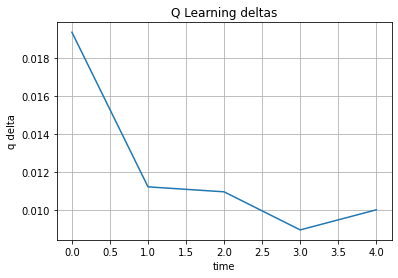


episode 100

you have flag
wait			-10.0000
random			-0.8353
go_opponent_flag			-1.7804
go_team_flag_area			3.5323
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-0.9655
go_nearest_teammate			-0.6234
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.9846
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.0491
guard_opponent_flag_area			-1.5194
run_away_from_nearest_opponent			-0.6171
run_away_from_opponents_centroid			-0.7432

opponent has flag and is close:
wait			-10.0000
random			-1.2354
go_opponent_flag			-0.1807
go_team_flag_area			-0.1190
go_opponent_flag_carrier			-0.0807
go_nearest_opponent			-0.4901
go_nearest_teammate			-0.3988
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.6365
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.0387
guard_opponent_flag_area			-0.4961
run_away_from_nearest_opponent			-0.5483
run_away_from_opponents_centroid			-0.8346


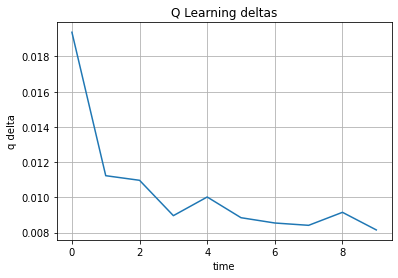


episode 150

you have flag
wait			-10.0000
random			-0.2093
go_opponent_flag			-1.2396
go_team_flag_area			1.6469
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-1.4246
go_nearest_teammate			-0.7208
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.5839
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.1512
guard_opponent_flag_area			-1.2326
run_away_from_nearest_opponent			-0.4750
run_away_from_opponents_centroid			0.1599

opponent has flag and is close:
wait			-10.0000
random			-0.3828
go_opponent_flag			-0.1981
go_team_flag_area			-0.1031
go_opponent_flag_carrier			0.4632
go_nearest_opponent			1.3620
go_nearest_teammate			-0.3403
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			0.0869
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.4047
guard_opponent_flag_area			-0.1807
run_away_from_nearest_opponent			-0.4251
run_away_from_opponents_centroid			-0.4630


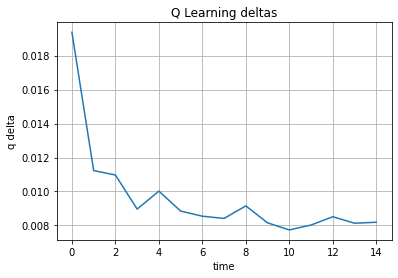


episode 200

you have flag
wait			-10.0000
random			-0.6259
go_opponent_flag			-0.8318
go_team_flag_area			3.2324
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-1.1971
go_nearest_teammate			-0.3398
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.0105
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.1790
guard_opponent_flag_area			-1.1685
run_away_from_nearest_opponent			-1.1492
run_away_from_opponents_centroid			-0.6516

opponent has flag and is close:
wait			-10.0000
random			-0.7037
go_opponent_flag			-0.1852
go_team_flag_area			-0.3332
go_opponent_flag_carrier			0.5286
go_nearest_opponent			0.1618
go_nearest_teammate			-0.3200
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.5196
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.5037
guard_opponent_flag_area			-0.4138
run_away_from_nearest_opponent			-0.7629
run_away_from_opponents_centroid			-1.5588


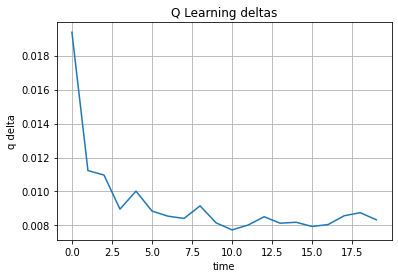


episode 250

you have flag
wait			-10.0000
random			-0.8203
go_opponent_flag			-0.8251
go_team_flag_area			2.5222
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-0.7284
go_nearest_teammate			-0.4704
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.7034
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.2763
guard_opponent_flag_area			-1.2965
run_away_from_nearest_opponent			-1.0871
run_away_from_opponents_centroid			-0.7329

opponent has flag and is close:
wait			-10.0000
random			-0.4884
go_opponent_flag			-0.1588
go_team_flag_area			-0.0401
go_opponent_flag_carrier			0.4227
go_nearest_opponent			0.0710
go_nearest_teammate			-0.5975
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.3948
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.2241
guard_opponent_flag_area			-0.5174
run_away_from_nearest_opponent			-0.8346
run_away_from_opponents_centroid			-0.8721


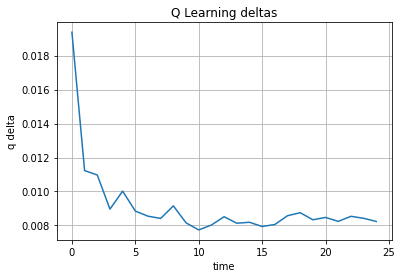


episode 300

you have flag
wait			-10.0000
random			-0.7376
go_opponent_flag			-1.2929
go_team_flag_area			1.4482
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-1.2626
go_nearest_teammate			0.3851
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-1.0317
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.3136
guard_opponent_flag_area			-1.1089
run_away_from_nearest_opponent			-0.8773
run_away_from_opponents_centroid			-0.7266

opponent has flag and is close:
wait			-10.0000
random			-1.9038
go_opponent_flag			-0.4028
go_team_flag_area			0.3211
go_opponent_flag_carrier			0.4274
go_nearest_opponent			-0.9985
go_nearest_teammate			-0.4148
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.5724
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			-0.1893
guard_opponent_flag_area			-0.5006
run_away_from_nearest_opponent			-1.6673
run_away_from_opponents_centroid			-2.0453


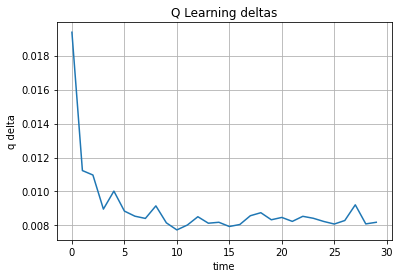


episode 350

you have flag
wait			-10.0000
random			-0.2576
go_opponent_flag			-0.9291
go_team_flag_area			2.8417
go_opponent_flag_carrier			-10.0000
go_nearest_opponent			-0.9125
go_nearest_teammate			-0.6063
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.4882
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			1.0848
guard_opponent_flag_area			-1.0076
run_away_from_nearest_opponent			-0.6010
run_away_from_opponents_centroid			-0.9525

opponent has flag and is close:
wait			-10.0000
random			-0.5327
go_opponent_flag			-0.0757
go_team_flag_area			0.2818
go_opponent_flag_carrier			0.5844
go_nearest_opponent			0.3080
go_nearest_teammate			0.0584
go_nearest_incapacitated_teammate			-10.0000
gaurd_nearest_teammate			-0.1054
gaurd_teammate_flag_carrier			-10.0000
gaurd_team_flag_area			0.3353
guard_opponent_flag_area			-0.1280
run_away_from_nearest_opponent			-1.0387
run_away_from_opponents_centroid			-0.2628


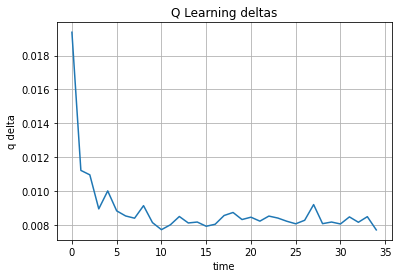

KeyboardInterrupt: 

In [6]:
config = Config(verbose=False)
config.blue_team_size = 5
config.red_team_size = 5
trainer = PolicyTrainer(Policy(), config)
trainer.train()

In [179]:
game = VirtualGame(Config())
game.the_map.tile_speeds[4,38]

7.0

In [174]:
game.the_map.get_direction_to_xy((5,7), (1,6))

'a'

In [181]:
player = VirtualPlayer('red', 1, game.the_map, (15,5))
other_player = VirtualPlayer('red', 0, game.the_map, (25,15))
opponent_player = VirtualPlayer('blue', 0, game.the_map, (5,15))
action = game.the_map.go_between(player.xy, other_player.xy, opponent_player.xy)
action, player.xy, other_player.xy, opponent_player.xy

('s', (15, 5), (25, 15), (5, 15))

In [43]:

ttl=0
st_cts={}
with open('state_counts.txt') as f:
    f.readline()
    for line in f:
        items = line[:-1].split('\t')
        st = tuple([int(i) for i in items[:-1]])
        ct=int(items[-1])
        ttl+=ct
        st_cts[st]=ct
sorted_states = [(st,st_cts[st]) for st in sorted(st_cts, key=st_cts.get, reverse=True)]

st_probs = {st:ct/ttl for st,ct in sorted_states}
len(st_probs)

In [44]:
import pickle
with open('state_probs.pkl', 'wb') as o:
    pickle.dump(st_probs,o)

In [53]:
p = Policy()
q = np.load('q.npy')
print(q.shape)
for i in range(q.shape[0]):
    print('\n')
    hls = []
    for j in range(len(p.high_level_states)):
        #print(i,j)
        if p.high_level_state_codes[i][j]:
            hls.append(p.high_level_states[j])
            
    print(', '.join(hls))
    
    if np.sum(q[i,:])==-140:
        print('\tstate never reached')
    else:
        for j in range(len(p.high_level_actions)):
            print('\t%s\t\t\t%.4f' % (p.high_level_actions[j], q[i,j]))

(512, 14)



	wait			-10.0000
	random			5.9797
	go_opponent_flag			6.1466
	go_team_flag_area			6.2836
	go_opponent_flag_carrier			-10.0000
	go_nearest_opponent			10.0094
	go_nearest_teammate			5.5210
	go_nearest_incapacitated_teammate			-10.0000
	gaurd_nearest_teammate			5.1328
	gaurd_teammate_flag_carrier			-10.0000
	gaurd_team_flag_area			7.5595
	guard_opponent_flag_area			7.7274
	run_away_from_nearest_opponent			12.7533
	run_away_from_opponents_centroid			7.0194


nearest_opponent_incapacitated
	wait			-10.0000
	random			10.3737
	go_opponent_flag			8.1283
	go_team_flag_area			9.2704
	go_opponent_flag_carrier			-10.0000
	go_nearest_opponent			8.6908
	go_nearest_teammate			9.7391
	go_nearest_incapacitated_teammate			-10.0000
	gaurd_nearest_teammate			9.5686
	gaurd_teammate_flag_carrier			-10.0000
	gaurd_team_flag_area			10.5414
	guard_opponent_flag_area			7.6801
	run_away_from_nearest_opponent			11.3834
	run_away_from_opponents_centroid			12.8343


nearest_opponent_has_flag
	state nev

In [ ]:
def train(self):
        deltas = []
        ep_deltas = []
        state_cts = {}
        state_to_monitor1 = (1,0,0,1,0,0,0,0,0) #''opponents_flag_in_play, 'self_has_flag'
        state_to_monitor2 = (0,1,0,0,0,0,0,1,0) #opponent has flag and is near
        monitor_idx1 = self.policy.high_level_state_codes.index(state_to_monitor1)
        monitor_idx2 = self.policy.high_level_state_codes.index(state_to_monitor2)
        
        #each episode
        for i in range(self.episodes):
            if i and i%10==0:        
                deltas.append(sum(ep_deltas)/len(ep_deltas))  
                ep_deltas = []
                
            if i and i%50==0:
                print('\nepisode', i)
                print('\nyou have flag')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx1,j]))
                print('\nopponent has flag and is close:')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx2,j]))
                self.__plot(deltas)
                np.save('q.npy', self.policy.q)
                with open('state_counts.txt', 'w') as o:
                    o.write('%s\n' % '\t'.join(self.policy.high_level_states))
                    for st,ct in state_cts.items():
                        o.write('%s\t%d\n' % ('\t'.join([str(s) for s in st]), ct))
                
            #create virtual game, map, and players
            game = VirtualGame(self.config)
            
            #when game is over, do one more pass over players, skipping the person who won the game and was rewarded
            game_over = False
            skip_team_idx = ()
            final_scores = False
            
            #track if the state has changed for a player and only choose new HLA then
            player_prev_state_action = {'%s_%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
            
            new_q = self.policy.q.copy()
            for j in range(10000): #cut game off after x steps
                random.shuffle(game.the_map.players)
                for player in game.the_map.players:
                    idx = '%s_%d' % (player.team, player.player_idx)
                    prev_state, prev_action = player_prev_state_action[idx]
                    
                    if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
                        #flag that we're assigning final scores
                        final_scores = True
                        continue
                        
                    #get game state for this player
                    state = self.policy.get_high_level_state(player.team, player.player_idx, game.the_map)
                
                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1
                
                    #only choose new action if state has changed for this player or with probability
                    if state==prev_state and random.random()>0.02:
                        action = prev_action
                        #print('using prev action', action)
                    #elif random.random()<(i/self.episodes):
                    #    action = self.choose_action_by_policy(player, game.the_map, state)
                        #print('choosing action by policy', action)
                    else:
                        #explore actions: For each state, select any one among all possible actions for the current state (S).
                        action = random.choice(self.policy.get_available_hlas(player, game.the_map, state))
                        #update player state, action
                        player_prev_state_action[idx] = (state, action)
                        #print('choosing random action', action)

                    #execute the hla and get the immediate reward for the new state
                    reward, game_over = game.step(player, action)
                    
                    #Travel to the next state (S') as a result of that action (a).
                    new_state = self.policy.get_high_level_state(player.team, player.player_idx, game.the_map)

                    #For all possible actions from the state (S') select the one with the highest Q-value.
                    best_action = ''
                    best_value = -float('inf')
                    for pos_action in self.policy.get_available_hlas(player, game.the_map, new_state):
                        new_state_idx = self.policy.high_level_state_codes.index(new_state)
                        pos_action_idx = self.policy.high_level_actions.index(pos_action)
                        value = self.policy.q[new_state_idx, pos_action_idx]
                        if value>best_value:
                            best_action = pos_action
                            best_value = value

                    #get previous Q value for computing delta
                    state_idx = self.policy.high_level_state_codes.index(state)
                    action_idx = self.policy.high_level_actions.index(action)
                    prev_val = self.policy.q[state_idx, action_idx]

                    #calculate the utility
                    utility = (1 - self.alpha)* prev_val + self.alpha*(reward + self.discount*best_value)
                    new_q[state_idx, action_idx] = utility

                    #store the delta for plotting
                    ep_deltas.append(abs(new_q[state_idx, action_idx] - prev_val))

                    #Set the next state as the current state.
                    state = new_state

                    #If goal state is reached, then end and repeat the process.
                    if game_over:
                        if not skip_team_idx:
                            skip_team_idx=(player.team, player.player_idx)
                            break
                
                #has the last pass to assign final scores occurred?
                if game_over and final_scores:
                    #print('game completed at', j)
                    #should q only be updated after a completed game?
                    self.policy.q = new_q
                    break
                    
        print(len(state_cts))
        for st,ct in state_cts.items():
            print(st, ct)
        self.__plot(deltas)